In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# konlpy, Mecab 형태소 분석기 설치 스크립트 실행
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from nltk import FreqDist
import math
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
import plotly.express as px

In [ ]:
# 정상 동작 확인
from konlpy.tag import Okt, Mecab

okt = Okt()
mecab = Mecab()

In [ ]:
total=pd.read_csv('/content/drive/MyDrive/올리브영 리뷰 크롤링/oliveyoung_review(20230502).csv')

In [ ]:
total=total[~total['review_text'].isnull()]

# 전처리

In [ ]:
ad=total[total['review_date'].str.contains('체험단')]
non_ad=total[~total['review_date'].str.contains('체험단')]

In [ ]:
ad_group=ad.groupby('product_name').count()[['review_text']]
non_ad_group=non_ad.groupby('product_name').count()[['review_text']]

ad_group.reset_index(inplace=True)
non_ad_group.reset_index(inplace=True)

In [ ]:
def remove_outlier(df=None, column=None, weight=1.5):
  quantile_25 = np.percentile(df[column].values, 25)
  quantile_75 = np.percentile(df[column].values, 75)

  IQR = quantile_75 - quantile_25
  IQR_weight = IQR*weight
  
  lowest = quantile_25 - IQR_weight
  highest = quantile_75 + IQR_weight
  
  removed_df = df[(df[column] >= lowest) & (df[column] <= highest) ]
  return removed_df

In [ ]:
ad_group=remove_outlier(df=ad_group, column='review_text', weight=1.5)
non_ad_group=remove_outlier(df=non_ad_group, column='review_text', weight=1.5)

In [ ]:
target_product=pd.merge(ad_group, non_ad_group, how='inner', on='product_name')
target_product=list(target_product['product_name'])

In [ ]:
ad_review=ad[ad['product_name'].isin(target_product)]
non_ad_review=non_ad[non_ad['product_name'].isin(target_product)]
ad_review.reset_index(inplace=True, drop=True)
non_ad_review.reset_index(inplace=True, drop=True)

# 단어 수 카운트

In [ ]:
tokenizer = Mecab()

In [ ]:
# 전처리
ad_review['review_text'] = ad_review['review_text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]"," ")
non_ad_review['review_text'] = non_ad_review['review_text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]"," ")

In [ ]:
stopwords=pd.read_excel('/content/drive/MyDrive/불용어.xlsx', header=None)

In [ ]:
stopwords=list(stopwords[0])

In [ ]:
ad_review_word_cnt=[]
for sentence in tqdm(ad_review['review_text']):
  temp = tokenizer.morphs(sentence) # 토큰화
  temp = [word for word in temp if not word in stopwords] # 불용어 제거
  ad_review_word_cnt.append([sentence, len(temp)])


100%|██████████| 27898/27898 [01:35<00:00, 293.24it/s]


In [ ]:
non_ad_review_word_cnt=[]
for sentence in tqdm(non_ad_review['review_text']):
  temp = tokenizer.morphs(sentence) # 토큰화
  temp = [word for word in temp if not word in stopwords] # 불용어 제거
  non_ad_review_word_cnt.append([sentence, len(temp)])


100%|██████████| 39089/39089 [01:15<00:00, 519.48it/s]


In [ ]:
ad_token=pd.DataFrame(ad_review_word_cnt, columns=['review_text','token_cnt'])
non_ad_token=pd.DataFrame(non_ad_review_word_cnt, columns=['review_text','token_cnt'])

In [ ]:
ad_token['token_cnt'].mean()

140.19030037995554

In [ ]:
non_ad_token['token_cnt'].mean()

69.0725523804651

# 빈도수 비교

## 명사 워드클라우드

In [ ]:
tokenized_ad=[]
for sentence in tqdm(ad_review['review_text']):
    temp = tokenizer.pos(sentence) # 품사 태깅
    nouns = [temp[0] for temp in temp if temp[1].startswith('N')] # 명사 추출
    tokenized_ad.append(nouns)

100%|██████████| 27898/27898 [00:45<00:00, 610.84it/s]


In [ ]:
tokenized_non_ad=[]
for sentence in tqdm(non_ad_review['review_text']):
    temp = tokenizer.pos(sentence) # 품사 태깅
    nouns = [temp[0] for temp in temp if temp[1].startswith('N')] # 명사 추출
    tokenized_non_ad.append(nouns)

100%|██████████| 39089/39089 [00:33<00:00, 1173.68it/s]


In [ ]:
len(tokenized_ad)

27898

In [ ]:
vocab_ad = FreqDist(np.hstack(tokenized_ad))
print('단어 집합의 크기 : {}'.format(len(vocab_ad)))

단어 집합의 크기 : 17290


In [ ]:
vocab_non_ad = FreqDist(np.hstack(tokenized_non_ad))
print('단어 집합의 크기 : {}'.format(len(vocab_non_ad)))

단어 집합의 크기 : 15109


In [ ]:
vocab_size = 100
# 상위 vocab_size개의 단어만 보존
vocab_ad = vocab_ad.most_common(vocab_size)
print('단어 집합의 크기 : {}'.format(len(vocab_ad)))

단어 집합의 크기 : 100


In [ ]:
vocab_size = 100
# 상위 vocab_size개의 단어만 보존
vocab_non_ad = vocab_non_ad.most_common(vocab_size)
print('단어 집합의 크기 : {}'.format(len(vocab_non_ad)))

단어 집합의 크기 : 100


In [ ]:
ad_data=dict(vocab_ad)
non_ad_data=dict(vocab_non_ad)

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 

fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


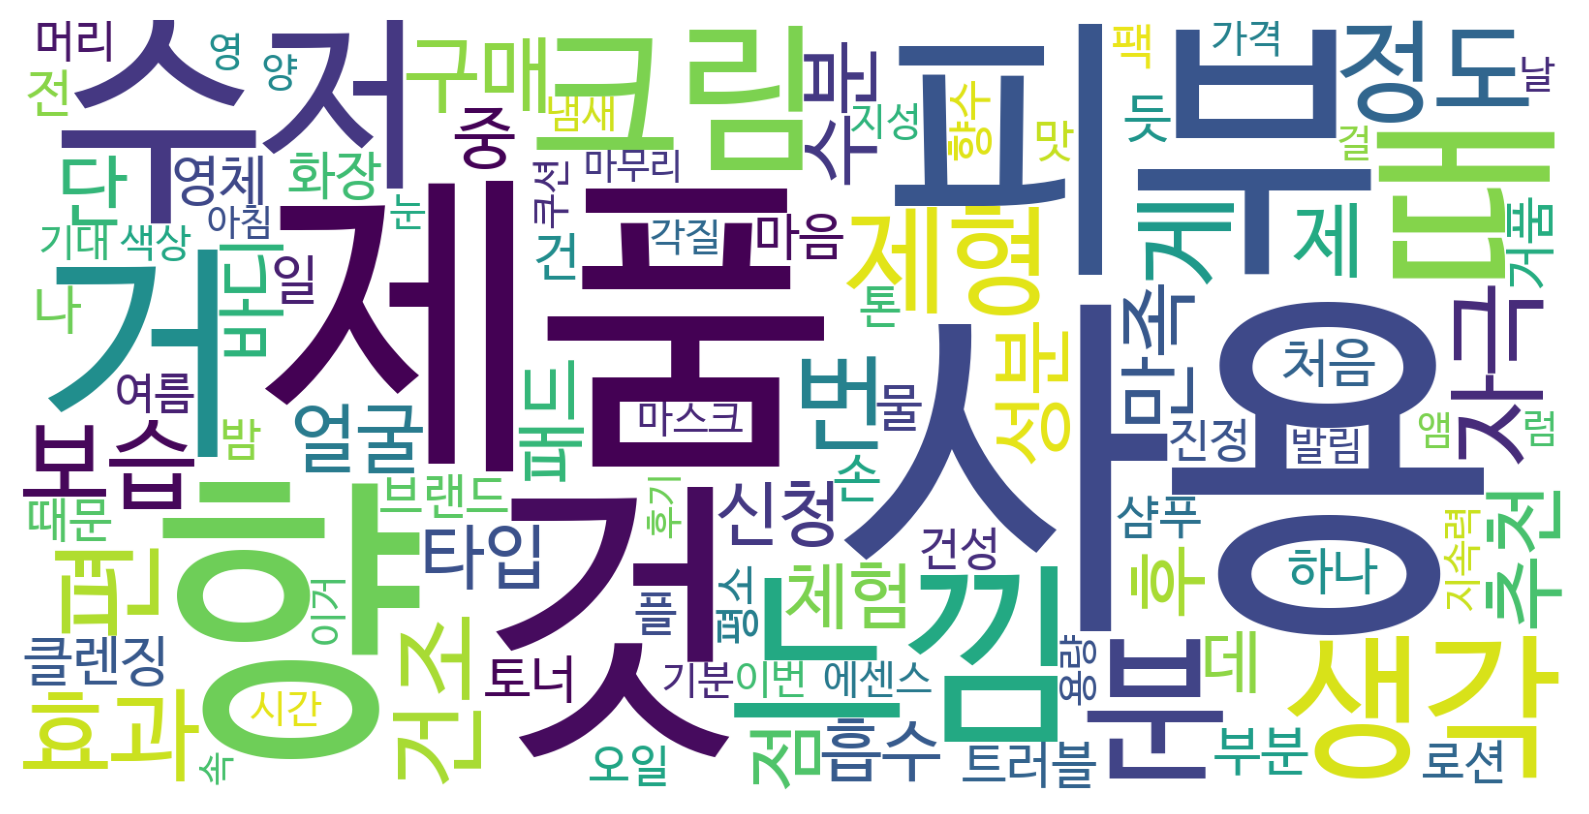

In [ ]:
wc = WordCloud(font_path=fontpath, #폰트
               background_color='white',                              #배경색
               width=1600, height=800)
#                max_words=200)                                         #단어갯수
cloud = wc.generate_from_frequencies(ad_data)                            #사전형태 데이터

plt.figure(figsize=(10,10))                                           #액자사이즈설정
plt.axis('off')                                                       #테두리 선 없애기

plt.imshow(cloud)

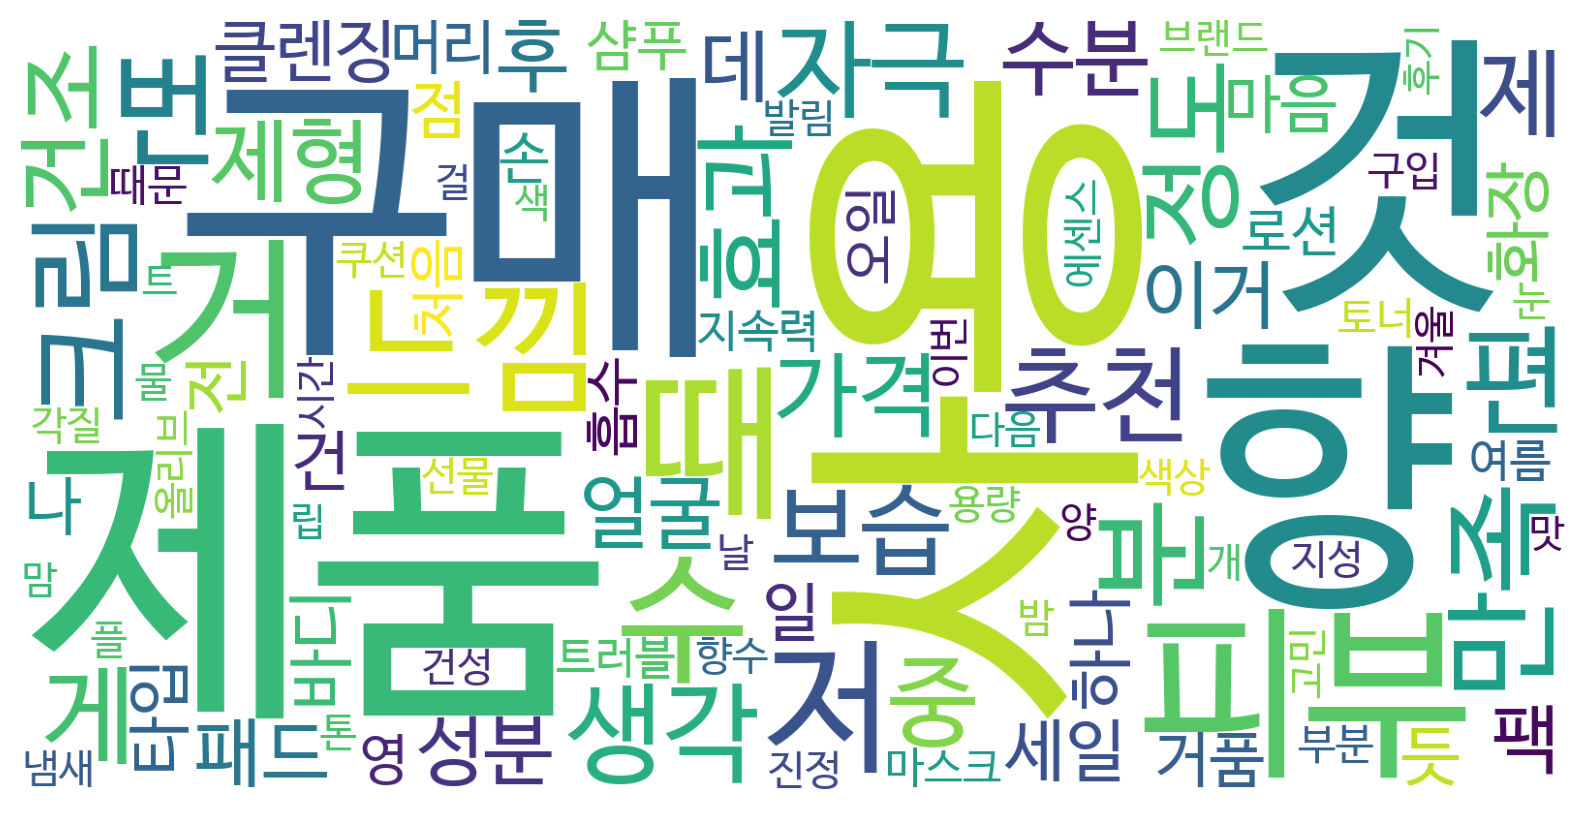

In [ ]:
wc = WordCloud(font_path=fontpath, #폰트
               background_color='white',                              #배경색
               width=1600, height=800)
#                max_words=200)                                         #단어갯수
cloud = wc.generate_from_frequencies(non_ad_data)                            #사전형태 데이터

plt.figure(figsize=(10,10))                                           #액자사이즈설정
plt.axis('off')                                                       #테두리 선 없애기

plt.imshow(cloud)

## 비교 표 생성

In [ ]:
ad_word=pd.DataFrame(vocab_ad, columns=['keyword', 'ad_cnt'])
non_ad_word=pd.DataFrame(vocab_non_ad, columns=['keyword', 'non_ad_cnt'])

In [ ]:
non_ad_word[non_ad_word['keyword']=='구매']

,non_ad_rank,keyword,non_ad_cnt
2,3,구매,21993


In [ ]:
ad_word[ad_word['keyword']=='구매']

,ad_rank,keyword,ad_cnt
22,23,구매,7590


In [ ]:
ad_word.reset_index(inplace=True)
non_ad_word.reset_index(inplace=True)
ad_word.rename(columns={'index':'ad_rank'}, inplace=True)
non_ad_word.rename(columns={'index':'non_ad_rank'}, inplace=True)

In [ ]:
ad_word['ad_rank']=ad_word['ad_rank'].astype(int)+1
non_ad_word['non_ad_rank']=non_ad_word['non_ad_rank'].astype(int)+1

In [ ]:
total_word=pd.merge(ad_word, non_ad_word, how='outer', on='keyword')

In [ ]:
total_word[total_word['ad_rank'].isnull()]

In [ ]:
total_word[total_word['non_ad_rank'].isnull()]

,ad_rank,keyword,ad_cnt,non_ad_rank,non_ad_cnt
29,30.0,단,6790.0,NaN,NaN
32,33.0,체험,5686.0,NaN,NaN
34,35.0,신청,5412.0,NaN,NaN
41,42.0,영체,4959.0,NaN,NaN
72,73.0,평소,3579.0,NaN,NaN
76,77.0,앰,3445.0,NaN,NaN
81,82.0,기대,3201.0,NaN,NaN
89,90.0,럼,3001.0,NaN,NaN
91,92.0,기분,2987.0,NaN,NaN
96,97.0,마무리,2792.0,NaN,NaN


## 연산

In [ ]:
total_word2=pd.merge(ad_word, non_ad_word, how='inner', on='keyword')

In [ ]:
total_word2['ad_rank-non_ad_rank']=total_word2['ad_rank']-total_word2['non_ad_rank']

In [ ]:
total_word2.sort_values(by='ad_rank-non_ad_rank').head(30)

,ad_rank,keyword,ad_cnt,non_ad_rank,non_ad_cnt,ad_rank-non_ad_rank
66,71,맛,3626,99,1878,-28
38,43,부분,4807,65,2545,-22
61,66,밤,3775,88,2026,-22
41,46,토너,4670,64,2649,-18
49,54,물,4341,72,2292,-18
29,31,점,6680,48,3064,-17
69,75,이번,3567,91,1995,-16
58,63,플,3971,79,2181,-16
53,58,브랜드,4189,73,2280,-15
13,14,제형,10249,28,4501,-14


In [ ]:
total_word2.sort_values(by='ad_rank-non_ad_rank', ascending=False).head(30)

,ad_rank,keyword,ad_cnt,non_ad_rank,non_ad_cnt,ad_rank-non_ad_rank
85,95,이거,2890,36,3592,59
70,76,가격,3467,27,4510,49
81,89,지속력,3034,59,2801,30
55,60,팩,4073,34,3605,26
84,94,쿠션,2908,70,2308,24
72,79,영,3319,58,2821,21
22,23,구매,7590,3,21993,20
65,70,머리,3708,51,2973,19
73,80,마스크,3274,63,2659,17
74,81,눈,3259,66,2459,15


## 글자 수 세기

In [ ]:
len_ad_text=[]
for sentence in tqdm(ad_review['review_text']):
  len_ad_text.append([sentence, len(sentence)])

100%|██████████| 27898/27898 [00:05<00:00, 5266.05it/s]


In [ ]:
len_non_ad_text=[]
for sentence in tqdm(non_ad_review['review_text']):
  len_non_ad_text.append([sentence, len(sentence)])

100%|██████████| 39089/39089 [00:05<00:00, 6893.98it/s]


In [ ]:
len_ad_df=pd.DataFrame(len_ad_text, columns=['review_text', 'text_cnt'])
len_non_ad_df=pd.DataFrame(len_non_ad_text, columns=['review_text', 'text_cnt'])

In [ ]:
len_ad_df['text_cnt'].mean()

382.9265538748297

In [ ]:
len_non_ad_df['text_cnt'].mean()

185.49384737394152

# 명사, 조사 추출

In [ ]:
ad_review_pos=[]
for sentence in tqdm(ad_review['review_text']):
  temp = tokenizer.pos(sentence) # 품사 태깅
  nouns = [temp[0] for temp in temp if temp[1].startswith('N')] # 명사 추출
  josas= [temp[0] for temp in temp if temp[1].startswith('J')] #조사 추출
  ad_review_pos.append([sentence, len(temp), len(nouns), len(josas)])

100%|██████████| 27898/27898 [00:50<00:00, 549.73it/s]


In [ ]:
non_ad_review_pos=[]
for sentence in tqdm(non_ad_review['review_text']):
  temp = tokenizer.pos(sentence) # 품사 태깅
  nouns = [temp[0] for temp in temp if temp[1].startswith('N')] # 명사 추출
  josas= [temp[0] for temp in temp if temp[1].startswith('J')] #조사 추출
  non_ad_review_pos.append([sentence, len(temp),len(nouns), len(josas)])

100%|██████████| 39089/39089 [00:30<00:00, 1290.20it/s]


In [ ]:
ad_pos=pd.DataFrame(ad_review_pos, columns=['review_text','morphs_cnt','noun_cnt', 'josa_cnt'])
non_ad_pos=pd.DataFrame(non_ad_review_pos, columns=['review_text', 'morphs_cnt','noun_cnt', 'josa_cnt'])

ad_pos['josa_percentage']=round(ad_pos['josa_cnt']/ad_pos['morphs_cnt'],2)
non_ad_pos['josa_percentage']=round(non_ad_pos['josa_cnt']/non_ad_pos['morphs_cnt'], 2)

ad_pos['noun_percentage']=round(ad_pos['noun_cnt']/ad_pos['morphs_cnt'],2)
non_ad_pos['noun_percentage']=round(non_ad_pos['noun_cnt']/non_ad_pos['morphs_cnt'], 2)

ad_pos['noun/josa_percentage']=round(ad_pos['noun_percentage']/ad_pos['josa_percentage'],2)
non_ad_pos['noun/josa_percentage']=round(non_ad_pos['noun_percentage']/non_ad_pos['josa_percentage'], 2)

ad_pos=ad_pos[~((ad_pos['noun/josa_percentage']==np.inf)|(ad_pos['noun/josa_percentage'].isnull()))]
non_ad_pos=non_ad_pos[~((non_ad_pos['noun/josa_percentage']==np.inf)|(non_ad_pos['noun/josa_percentage'].isnull()))]

In [ ]:
print(ad_pos['noun/josa_percentage'].mean()), print(non_ad_pos['noun/josa_percentage'].mean())

2.41077201793722
2.719207519845527


(None, None)

In [ ]:
ad_pos['type']='ad'
non_ad_pos['type']='non_ad'
total_pos=pd.concat([ad_pos, non_ad_pos])
total_pos.reset_index(inplace=True, drop=True)

In [ ]:
fig = px.scatter(total_pos, x="josa_percentage", y="noun/josa_percentage", color="type")
fig.show()

# TF-IDF

In [ ]:
total['review_point']=total['review_point'].apply(lambda x:str(x).split(' ')[1])

In [ ]:
total_1=total[total['review_point']=='1점']
total_5=total[total['review_point']=='5점']

In [ ]:
total_1.shape, total_5.shape

((8818, 13), (1381835, 13))

In [ ]:
product_list_1=list(total_1.product_name.unique())
total_5=total_5[total_5['product_name'].isin(product_list_1)]

In [ ]:
total_1.shape, total_5.shape

((8818, 13), (902339, 13))

In [ ]:
docs = '''오늘은 매우 좋은 날씨 입니다
내일도 매우 좋은 날씨를 기대합니다
토픽 모형을 이용하여 문서를 모형에 적합시켜 문서 내용을 분석하는 방법은 매우 쉽다고 생각할 수 있습니다'''
doc_list = docs.split('\n') 
doc_list = [v for v in doc_list if v]
print(len(doc_list))

3


In [ ]:
import konlpy

In [ ]:
docs_list =[]
for doc in doc_list:
    nouns = konlpy.tag.Okt().nouns(doc)
    docs_list.append(' '.join(nouns))
print(docs_list)

['오늘 매우 날씨', '내일 매우 날씨', '토픽 모형 이용 문서 모형 적합 문서 내용 분석 방법 매우 생각 수']


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer() #vocabulary=vocab 지정 또는 미지정 가능
dtm = vect.fit_transform(docs_list).toarray()
vocab = vect.get_feature_names_out()
pd.DataFrame(dtm, columns=vocab)

,날씨,내용,내일,매우,모형,문서,방법,분석,생각,오늘,이용,적합,토픽
0,1,0,0,1,0,0,0,0,0,1,0,0,0
1,1,0,1,1,0,0,0,0,0,0,0,0,0
2,0,1,0,1,2,2,1,1,1,0,1,1,1


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfv = TfidfVectorizer(vocabulary=vocab)
tfidf = tfidfv.fit_transform(docs_list).toarray()
pd.DataFrame(tfidf, columns=vocab)

,날씨,내용,내일,매우,모형,문서,방법,분석,생각,오늘,이용,적합,토픽
0,0.547832,0.000000,0.000000,0.425441,0.000000,0.000000,0.000000,0.000000,0.000000,0.720333,0.000000,0.000000,0.000000
1,0.547832,0.000000,0.720333,0.425441,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.255248,0.000000,0.150754,0.510496,0.510496,0.255248,0.255248,0.255248,0.000000,0.255248,0.255248,0.255248


In [ ]:
tfidf_order = np.flip(np.argsort(tfidf, axis=-1), axis=-1)
topics =[]
n_top = 2
for line in tfidf_order:
  topic = [vocab[x] for x in line[:n_top]]
  topics.append(topic)
df = pd.DataFrame(topics)
df

,0,1
0,오늘,날씨
1,내일,날씨
2,문서,모형
